In [296]:
#Imports
import pandas as pd
import numpy as np
from numpy import array
from keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, time
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, TimeDistributed, Conv2D, MaxPooling2D, Flatten

In [297]:
#Read in the pickled dataframe from GH_Capstone2_accident notebook
all_coords_df = pd.read_pickle('all_coords_df.pkl')

In [298]:
all_coords_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1293094 entries, 2019-04-16 00:00:00 to 2012-07-01 09:59:00
Data columns (total 6 columns):
date         1293094 non-null datetime64[ns]
time         1293094 non-null object
longitude    1293094 non-null float64
latitude     1293094 non-null float64
y            1293094 non-null float64
x            1293094 non-null float64
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 69.1+ MB


In [299]:
all_coords_df.head()

,date,time,longitude,latitude,y,x
datetime,,,,,,
2019-04-16,2019-04-16,0:00,-73.98091,40.737885,586046.344512,4.510160e+06
2019-04-16,2019-04-16,0:00,-73.82261,40.762756,599375.548769,4.513088e+06
2019-04-16,2019-04-16,0:00,-73.82282,40.729404,599407.480337,4.509385e+06
2019-04-16,2019-04-16,0:00,-73.75374,40.665485,605341.759287,4.502370e+06
2019-04-16,2019-04-16,0:00,-73.95117,40.810173,588461.524222,4.518214e+06


In [300]:

#Determining limits of data
ymin = all_coords_df.y.min()
ymax = all_coords_df.y.max()
yrange = (ymax - ymin) / 33 #ground distance of each square in histogam below
xmin = all_coords_df.x.min()
xmax = all_coords_df.x.max()
datemin = all_coords_df.date.min()
datemax = all_coords_df.date.max()
xrange = (xmax - xmin) / 33 #ground distance of each square in histogram below
print(f"The max and min values for y and x are: {ymin}, {ymax}, {xmin} and {xmax}")
print(f'One square represents: x: {xrange}, y: {yrange} meters')
print(f'Date range is from {datemin} to {datemax}')

The max and min values for y and x are: 563160.1705779731, 612885.3478294573, 4483412.260444801 and 4529666.189655863
One square represents: x: 1401.6342185170136, y: 1506.8235530752765 meters
Date range is from 2012-07-01 00:00:00 to 2019-04-16 00:00:00


Below we will define the size of the histogram by ucreating two arrays containing the bins defined by taking the extreme values of lat and long and dividing them up evenly. WIll then fill in the accident data for the entire dataset as a test. Next step will want to be able to select the hour period.

In [301]:
#setting up 2D array. divide max and min values of coordinates into regular intervals
yedges = np.linspace(ymin, ymax, 33) #330
xedges = np.linspace(xmin, xmax, 33) #330

#generate the histogram using bins defined above
test_hist, yedges, xedges  = np.histogram2d(all_coords_df['y'], all_coords_df['x'], \
                                            bins=(yedges, xedges))
test_hist.shape, type(test_hist)
test_hist

array([[5.2000e+02, 3.8400e+02, 1.7700e+02, 5.3000e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00],
       [1.8600e+02, 6.8500e+02, 6.4800e+02, 5.0500e+02, 5.2000e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00],
       [3.9000e+01, 4.9200e+02, 7.5500e+02, 5.3800e+02, 4.8600e+02,
        0.0000e+00, 1.2000e+01, 0.0000e+00, 0.0000

Let's do some math: 365 days * 24 hours = 8760 2D rastors
I don't think for this project its feasable to do hourly rastors across the whole timeframe. Let's do last 6 months, leaving the last month as the test set?

min date = Dec 16 2018
max date = Apr 16 2019

1. nested loop for day and hour.
2. create a 2D histogram for all day and hour combinations. write to a numpy array
3. test case on 10 days

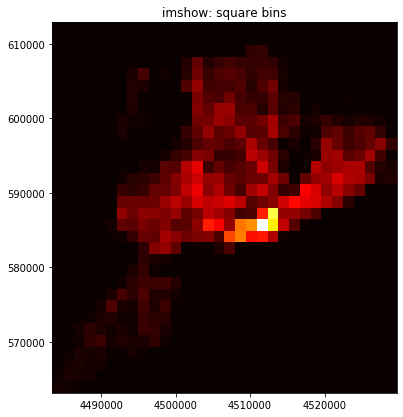

In [302]:
###Testing
#plot the histogram using np.imshow
fig = plt.figure(figsize=(21, 21))
ax = fig.add_subplot(131, title='imshow: square bins')
_ = plt.imshow(test_hist, interpolation='nearest', cmap='hot', origin='low',
         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

***NOTE*** need to work out how to reverse the X-axis. Image is flipped horizontally/

In [303]:
len(all_coords_df.x), yedges

(1293094,
 array([563160.17057797, 564714.08236708, 566267.99415619, 567821.9059453 ,
        569375.81773441, 570929.72952352, 572483.64131263, 574037.55310174,
        575591.46489084, 577145.37667995, 578699.28846906, 580253.20025817,
        581807.11204728, 583361.02383639, 584914.9356255 , 586468.84741461,
        588022.75920372, 589576.67099282, 591130.58278193, 592684.49457104,
        594238.40636015, 595792.31814926, 597346.22993837, 598900.14172748,
        600454.05351659, 602007.9653057 , 603561.8770948 , 605115.78888391,
        606669.70067302, 608223.61246213, 609777.52425124, 611331.43604035,
        612885.34782946]))

In [304]:
#Trying to use datetime objects
# write a loop to select date and hour start with last 6 months
#get a list of each unique date
unique_date = np.unique(all_coords_df.date.dt.date) # return unique instances of just YYY-MM-DD
list_of_accidents = []
#loop over them
for i in pd.date_range(start='12-16-2018', end='4-16-2019', freq='H'):
    clear_output(wait=True)
# generate the individual histograms
    test_hist, yedges, xedges  = np.histogram2d(all_coords_df.loc[(all_coords_df.index >= i) & \
                                    (all_coords_df.index < (i + timedelta(hours=1)))].y, \
                                    all_coords_df.loc[(all_coords_df.index >= i) & \
                                    (all_coords_df.index < (i + timedelta(hours=1)))].x, bins=(yedges, xedges))
    list_of_accidents.append(test_hist)
    print(len(list_of_accidents))
    
#convert the list or arrays into a numpy array
array_of_accidents = np.array(list_of_accidents)
print('array shape:', array_of_accidents.shape)
#array_of_accidents_reshape = array_of_accidents.reshape(2905,32,32,1)

2905
array shape: (2905, 32, 32)


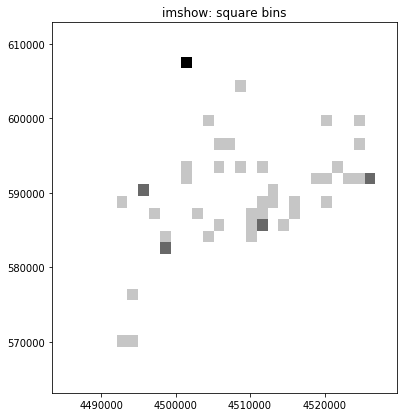

In [305]:
#plot the histogram using np.imshow
fig = plt.figure(figsize=(21, 21))
ax = fig.add_subplot(131, title='imshow: square bins')
_ = plt.imshow(array_of_accidents[17], interpolation='nearest', cmap='Greys', origin='low',
         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

In [306]:
#what are the dimensions?
print(array_of_accidents.shape, len(array_of_accidents) / 7) #how many time steps


#want approx 10% for test set. Choose 294
train_array = array_of_accidents_reshape[:-294]
test_array = array_of_accidents_reshape[-294:]


len(train_array), len(test_array)

(2905, 32, 32) 415.0


(2611, 294)

We want to create a 2D array for every hour. These will all go into a single array, so we can use a function to choose how

In [310]:
#Define a generator to select data using keras TimeseriesGenerator
# length - number of lag observations to use in the input for each sample
# batch_size - 

n_input = 6 # Want to train on 6 to predict 7th
train_generator = TimeseriesGenerator(train_array, train_array, length=n_input, batch_size=1)
test_generator = TimeseriesGenerator(test_array, test_array, length=n_input, batch_size=1)
generator = TimeseriesGenerator(array_of_accidents, array_of_accidents, length=n_input, batch_size=1)
# number of samples
print('Samples: %d' % len(train_generator))
print('Length of generator:', len(train_generator))
# print each sample
for i in range(len(train_generator)):
    X, y = train_generator[i]
    #print('%s => %s' % (x, y))
X.shape, y.shape #what shape do X and y have 

Samples: 2605
Length of generator: 2605


((1, 6, 32, 32, 1), (1, 32, 32, 1))

I tried the three different ways, each using the same generator set up earlier. I think this is what I have to reshape, but I ahven't worked out how to yet...

# convLSTM

In [329]:
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np
import pylab as plt

# We create a layer which take as input movies of shape
# (n_frames, width, height, channels) and returns a movie
# of identical shape.

seq = Sequential()
seq.add(ConvLSTM2D(filters=32, kernel_size=1,
                   input_shape=(None, 32, 32, 1),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=32, kernel_size=1,
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

#seq.add(ConvLSTM2D(filters=32, kernel_size=1,
#                   padding='same', return_sequences=True))
#seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=32, kernel_size=1,
                   padding='same', return_sequences=False))
seq.add(BatchNormalization())

seq.add(Conv2D(filters=1, kernel_size=1,
               activation='sigmoid',
               padding='same', data_format='channels_last'))
seq.compile(loss='binary_crossentropy', optimizer='adadelta')
seq.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_67 (ConvLSTM2D) (None, None, 32, 32, 32)  4352      
_________________________________________________________________
batch_normalization_67 (Batc (None, None, 32, 32, 32)  128       
_________________________________________________________________
conv_lst_m2d_68 (ConvLSTM2D) (None, None, 32, 32, 32)  8320      
_________________________________________________________________
batch_normalization_68 (Batc (None, None, 32, 32, 32)  128       
_________________________________________________________________
conv_lst_m2d_69 (ConvLSTM2D) (None, 32, 32, 32)        8320      
_________________________________________________________________
batch_normalization_69 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 32, 32, 1)         33        
Total para

In [330]:
seq.fit_generator(train_generator, epochs=10) 

Epoch 1/10
2605/2605 [==============================] - 1645s 631ms/step - loss: 0.1113
Epoch 2/10
2605/2605 [==============================] - 1108s 425ms/step - loss: 0.0933
Epoch 3/10
2605/2605 [==============================] - 1000s 384ms/step - loss: 0.0932
Epoch 4/10
2605/2605 [==============================] - 996s 382ms/step - loss: 0.0931
Epoch 5/10
2605/2605 [==============================] - 937s 360ms/step - loss: 0.0931
Epoch 6/10
2605/2605 [==============================] - 931s 357ms/step - loss: 0.0930
Epoch 7/10
2605/2605 [==============================] - 926s 356ms/step - loss: 0.0930
Epoch 8/10
2605/2605 [==============================] - 933s 358ms/step - loss: 0.0930
Epoch 9/10
2605/2605 [==============================] - 932s 358ms/step - loss: 0.0930
Epoch 10/10
2605/2605 [==============================] - 933s 358ms/step - loss: 0.0930


In [331]:
seq.save('20191225_CONVLSTM2D.h5')

TypeError: Invalid shape (1, 32, 32, 1) for image data

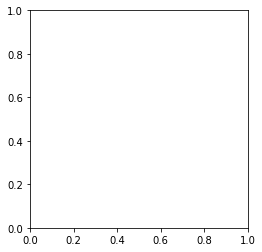

In [335]:
plt.imshow(y)

In [259]:

# univariate one step problem
from numpy import array
from keras.preprocessing.sequence import TimeseriesGenerator
# define dataset
series = array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
# define generator
n_input = 6
generator = TimeseriesGenerator(series, series, length=n_input, batch_size=1)
# number of samples
print('Samples: %d' % len(generator))
# print each sample
for i in range(len(generator)):
	x, y = generator[i]
	print('%s => %s' % (x, y))

Samples: 4
[[1 2 3 4 5 6]] => [7]
[[2 3 4 5 6 7]] => [8]
[[3 4 5 6 7 8]] => [9]
[[4 5 6 7 8 9]] => [10]


In [337]:
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np
import pylab as plt

# We create a layer which take as input movies of shape
# (n_frames, width, height, channels) and returns a movie
# of identical shape.

seq = Sequential()
seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   input_shape=(None, 40, 40, 1),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
seq.compile(loss='binary_crossentropy', optimizer='adadelta')
seq.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_74 (ConvLSTM2D) (None, None, 40, 40, 40)  59200     
_________________________________________________________________
batch_normalization_74 (Batc (None, None, 40, 40, 40)  160       
_________________________________________________________________
conv_lst_m2d_75 (ConvLSTM2D) (None, None, 40, 40, 40)  115360    
_________________________________________________________________
batch_normalization_75 (Batc (None, None, 40, 40, 40)  160       
_________________________________________________________________
conv_lst_m2d_76 (ConvLSTM2D) (None, None, 40, 40, 40)  115360    
_________________________________________________________________
batch_normalization_76 (Batc (None, None, 40, 40, 40)  160       
_________________________________________________________________
conv_lst_m2d_77 (ConvLSTM2D) (None, None, 40, 40, 40)  115360    
__________